In [ ]:
import numpy as np
import pickle
import time
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




Datasets successfully loaded.


Training/validation on 32450 samples (25 CCLs x 1298 DepOIs) and testing on 3894 samples (3 CCLs x 1298 DepOIs).


Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 7.2175 - val_loss: 0.2729
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3117 - val_loss: 0.2052
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2215 - val_loss: 0.1946
Epoch 4/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1992 - val_loss: 0.1744
Epoch 5/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1740 - val_loss: 0.1379
Epoch 6/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1482 - val_loss: 0.1068
Epoch 7/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1239 - val_loss: 0.0801
Epoch 8/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1080 - val_loss: 0.0696
Epoch 9/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0942 - val_loss: 0.0639
Epoch 10/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0883 - val_l

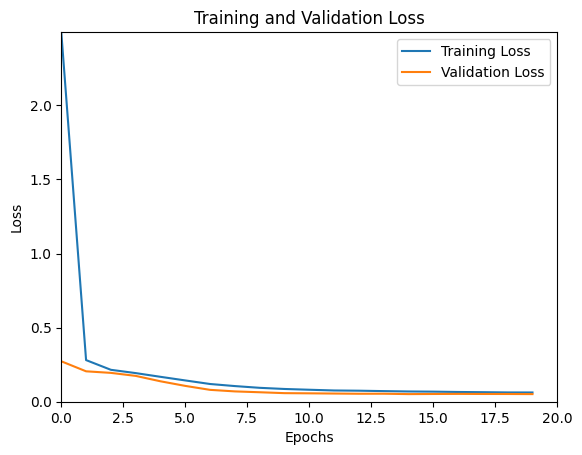


Evaluation metrics on test data:
MSE: 0.0446
RMSE: 0.2112
R-squared (R2): 0.7478
MAE: 0.1568
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Evaluation metrics on validation data:
MSE: 0.0478
RMSE: 0.2187
R-squared (R2): 0.7471
MAE: 0.1622

Binary Classification Metrics:
F1 Score: 0.5918
Recall (Sensitivity): 0.4289
Precision: 0.9540
Accuracy: 0.9412

Final training loss: 0.0623
Final validation loss: 0.0515


In [ ]:
if __name__ == '__main__':

    # Loading data
    with open('/content/drive/MyDrive/Colab Notebooks/Thesis/data/ccl_complete_data_28CCL_1298DepOI_36344samples_demo.pickle', 'rb') as f:
        data_mut, data_exp, data_cna, data_meth, data_dep, data_fprint = pickle.load(f)

    # Loading pretrained models
    premodel_mut = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_mut_100_50_25_demo.pickle', 'rb'))
    premodel_exp = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_exp_100_50_25_demo.pickle', 'rb'))
    premodel_cna = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_cna_100_50_25_demo.pickle', 'rb'))
    premodel_meth = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_meth_100_50_25_demo.pickle', 'rb'))
    print("\n\nDatasets successfully loaded.")

    # Defining model parameters
    activation_func = 'relu'  
    activation_func2 = 'linear'  
    init = 'he_uniform'
    dense_layer_dim = 50  
    batch_size = 64 
    num_epoch = 20  
    num_DepOI = 1298  
    dropout_gene_1 = 0.4
    dropout_gene_2 = 0.3
    num_ccl = int(data_mut.shape[0] / num_DepOI)

    # Splitting data into train/validation and test sets
    id_rand = np.random.permutation(num_ccl)
    id_cell_train = id_rand[np.arange(0, round(num_ccl * 0.9))]
    id_cell_test = id_rand[np.arange(round(num_ccl * 0.9), num_ccl)]

    id_train = np.arange(0, 1298) + id_cell_train[0] * 1298
    for y in id_cell_train:
        id_train = np.union1d(id_train, np.arange(0, 1298) + y * 1298)

    id_test = np.arange(0, 1298) + id_cell_test[0] * 1298
    for y in id_cell_test:
        id_test = np.union1d(id_test, np.arange(0, 1298) + y * 1298)

    print("\n\nTraining/validation on %d samples (%d CCLs x %d DepOIs) and testing on %d samples (%d CCLs x %d DepOIs).\n\n" % (
        len(id_train), len(id_cell_train), num_DepOI, len(id_test), len(id_cell_test), num_DepOI))


    # Defining subnetworks
    input_mut = Input(shape=(premodel_mut[0][0].shape[0],))
    x = layers.Dense(100, activation=activation_func, trainable=True)(input_mut)
    x = Dropout(0.2)(x) 
    x = layers.Dense(50, activation=activation_func, trainable=True)(x)
    x = Dropout(0.2)(x)  
    x = layers.Dense(25, activation=activation_func, trainable=True)(x)

    # Setting weights after layer definition
    model_mut = models.Model(input_mut, x)
    model_mut.layers[1].set_weights(premodel_mut[0])
    model_mut.layers[3].set_weights(premodel_mut[1])
    model_mut.layers[5].set_weights(premodel_mut[2])

    input_exp = Input(shape=(premodel_exp[0][0].shape[0],))
    x = layers.Dense(100, activation=activation_func, trainable=True)(input_exp)
    x = Dropout(0.2)(x)  
    x = layers.Dense(50, activation=activation_func, trainable=True)(x)
    x = Dropout(0.2)(x)  
    x = layers.Dense(25, activation=activation_func, trainable=True)(x)

    model_exp = models.Model(input_exp, x)
    model_exp.layers[1].set_weights(premodel_exp[0])
    model_exp.layers[3].set_weights(premodel_exp[1])
    model_exp.layers[5].set_weights(premodel_exp[2])

    input_cna = Input(shape=(premodel_cna[0][0].shape[0],))
    x = layers.Dense(100, activation=activation_func, trainable=True)(input_cna)
    x = Dropout(0.2)(x)  
    x = layers.Dense(50, activation=activation_func, trainable=True)(x)
    x = Dropout(0.2)(x)  
    x = layers.Dense(25, activation=activation_func, trainable=True)(x)

    model_cna = models.Model(input_cna, x)
    model_cna.layers[1].set_weights(premodel_cna[0])
    model_cna.layers[3].set_weights(premodel_cna[1])
    model_cna.layers[5].set_weights(premodel_cna[2])

    input_meth = Input(shape=(premodel_meth[0][0].shape[0],))
    x = layers.Dense(100, activation=activation_func, trainable=True)(input_meth)
    x = Dropout(0.2)(x)  
    x = layers.Dense(50, activation=activation_func, trainable=True)(x)
    x = Dropout(0.2)(x) 
    x = layers.Dense(25, activation=activation_func, trainable=True)(x)

    model_meth = models.Model(input_meth, x)
    model_meth.layers[1].set_weights(premodel_meth[0])
    model_meth.layers[3].set_weights(premodel_meth[1])
    model_meth.layers[5].set_weights(premodel_meth[2])

    input_gene = Input(shape=(data_fprint.shape[1],))
    x = layers.Dense(100, activation=activation_func, kernel_initializer=init, trainable=True)(input_gene)
    x = Dropout(0.5)(x)  
    x = layers.Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = Dropout(0.5)(x)  
    x = layers.Dense(25, activation=activation_func, kernel_initializer=init, trainable=True)(x)

    model_gene = models.Model(input_gene, x)

    # Merging subnetworks
    merged = layers.concatenate([model_mut.output, model_exp.output, model_cna.output, model_meth.output, model_gene.output])
    x = layers.Dense(dense_layer_dim, activation=activation_func, kernel_initializer=init, trainable=True)(merged)
    x = Dropout(0.2)(x)  
    x = layers.Dense(dense_layer_dim, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = Dropout(0.2)(x) 
    output = layers.Dense(1, activation=activation_func2, kernel_initializer=init, trainable=True)(x)

    model_final = models.Model(inputs=[model_mut.input, model_exp.input, model_cna.input, model_meth.input, model_gene.input], outputs=output)

    # Compiling and training the model
    optimizer = Adam(learning_rate=0.0001) 
    model_final.compile(loss='mse', optimizer=optimizer)


    history = model_final.fit(
        [data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], data_fprint[id_train]],
        data_dep[id_train], epochs=num_epoch, validation_split=1/9, batch_size=batch_size, shuffle=True, verbose=1)

    # Evaluating on test data
    y_pred = model_final.predict(
        [data_mut[id_test], data_exp[id_test], data_cna[id_test], data_meth[id_test], data_fprint[id_test]],
        batch_size=batch_size)

    # Calculating evaluation metrics
    mse = mean_squared_error(data_dep[id_test], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(data_dep[id_test], y_pred)
    mae = mean_absolute_error(data_dep[id_test], y_pred)


    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # Set x and y limits
    plt.xlim(0, num_epoch)
    plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))
    plt.legend()
    plt.show()

    # Printing evaluation metrics
    print(f"\nEvaluation metrics on test data:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"MAE: {mae:.4f}")


    # Evaluating on validation data
    val_predictions = model_final.predict(
        [data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], data_fprint[id_train]],
        batch_size=batch_size)

    # Calculating evaluation metrics for validation data
    val_mse = mean_squared_error(data_dep[id_train], val_predictions)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(data_dep[id_train], val_predictions)
    val_mae = mean_absolute_error(data_dep[id_train], val_predictions)

    print(f"\nEvaluation metrics on validation data:")
    print(f"MSE: {val_mse:.4f}")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"R-squared (R2): {val_r2:.4f}")
    print(f"MAE: {val_mae:.4f}")


    # binary classification metrics
    y_true_binary = np.where(data_dep[id_test] < -1, 1, 0)
    y_pred_binary = np.where(y_pred < -1, 1, 0)


    # F1 score, Recall, Precision, Accuracy
    f1 = f1_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    accuracy = accuracy_score(y_true_binary, y_pred_binary)

    # binary classification metrics
    print(f"\nBinary Classification Metrics:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    print(f"\nFinal training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
